In [143]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.interpolate import CubicSpline
import matplotlib.colors as mcolors


from functools import partial
import starsim

In [144]:
pathdata="/home/sophie-stucki/Documents/starsim_simulations/"
path_grid="/home/sophie-stucki/starsim/starsim/gif/"
conf_file_path = "/home/sophie-stucki/starsim/starsim/starsim_sun.conf"

In [145]:
period = 25
periods_nbr = 1
point_nbr = 5


t=np.linspace(0,period *periods_nbr,int(period *periods_nbr*point_nbr))

In [146]:
def simulation_init(Q_list, spot_size_list, latitude_list, longitude_list, conf_file_path, dT_fc=None):
    """
    Iniialization of the starsim simulation for a particular set of parameters

    Params:
            -Q: facular_area_ratio
    Return:
            - ss: starsim object

    """
    
    #create the starsim object
    ss=starsim.StarSim(conf_file_path=conf_file_path)


    #set the Q parameter
    ss.facular_area_ratio=Q_list

    if dT_fc !=None:
        ss.facula_T_contrast = dT_fc

    #initialize the spot
    overlap=True

    #TODO: more modulable
    Nspots=len(spot_size_list)
    ss.spot_map=np.zeros([Nspots,8])
    for j in range(Nspots):
        ss.spot_map[j][2]=200#lifetime spot
        ss.spot_map[j][1]=0#appearance time
        ss.spot_map[j][3]=latitude_list[j]#latitude (degrees) [0,180]
        ss.spot_map[j][4]=longitude_list[j]#longitude (degrees)	[0,360]
        ss.spot_map[j][5]=spot_size_list[j]#spot size (degrees)
    return ss

In [147]:
Q_list = [0, 10000]
spot_size_list = [3, 0.1]
latitude_list = [90, 60]
longitude_list = [200, 230]

Date 10.282258064516128. ff_ph=97.251%. ff_sp=0.267%. ff_fc=2.482%. ff_pl=0.000%. [52/125]%%

KeyboardInterrupt: 

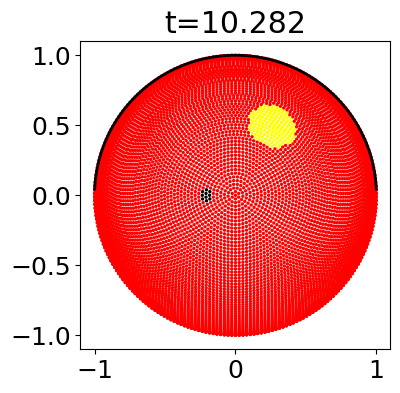

In [152]:
ss_tot = simulation_init(Q_list, spot_size_list, latitude_list, longitude_list, conf_file_path)
ss_tot.compute_forward(observables=['rv','lc'],t=t)

lc_tot = ss_tot.results['lc']
rv_tot = ss_tot.results['rv']
bis_tot = ss_tot.results['bis']

lc_list =[]
rv_list = []
bis_list = []

for i in range(len(Q_list)):
    ss = simulation_init([Q_list[i]], [spot_size_list[i]], [latitude_list[i]], [longitude_list[i]], conf_file_path)
    ss.compute_forward(observables=['rv','lc'],t=t)
    lc_list.append(ss.results['lc'])
    rv_list.append(ss.results['rv'])
    bis_list.append(ss.results['bis'])



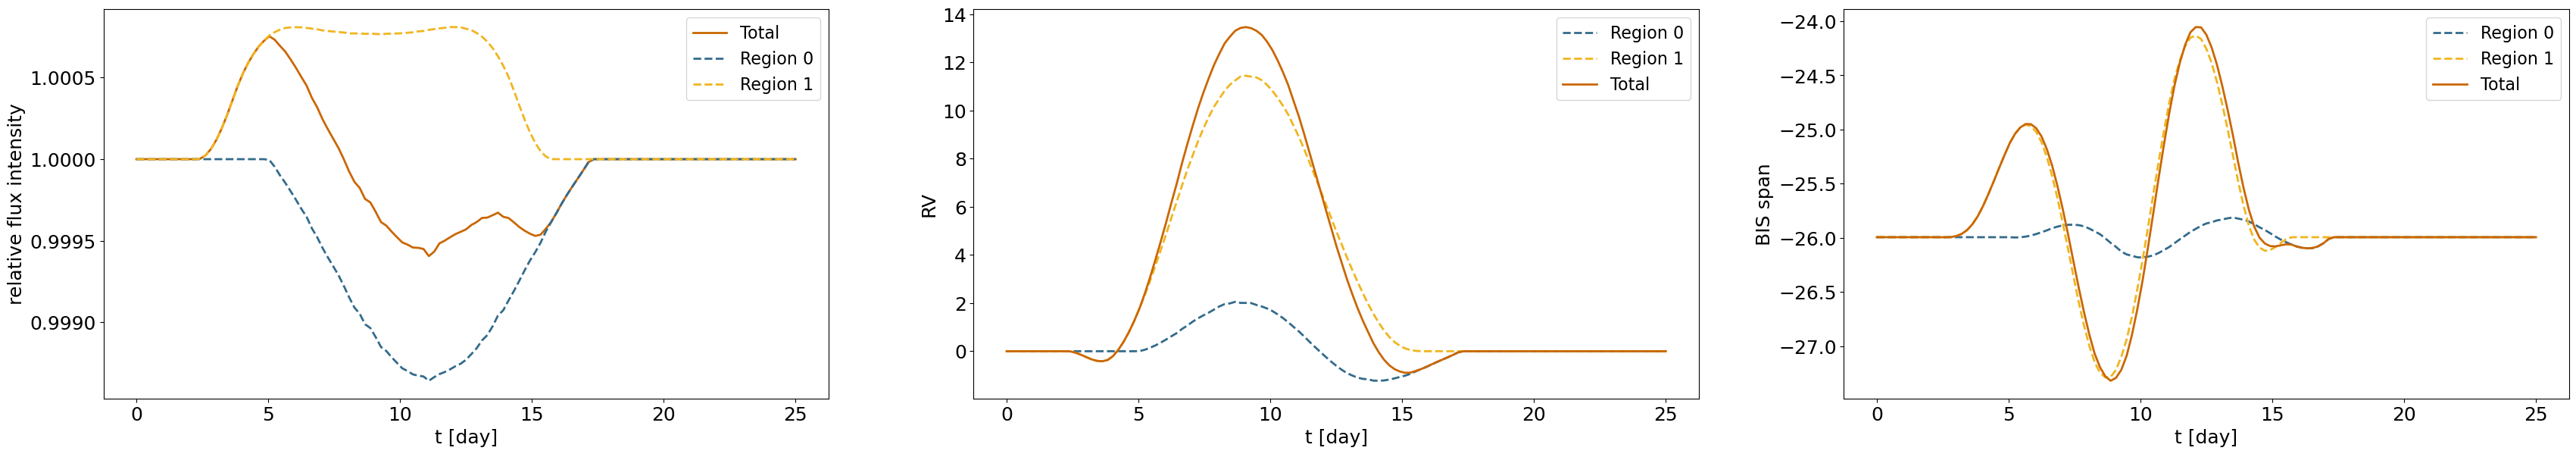

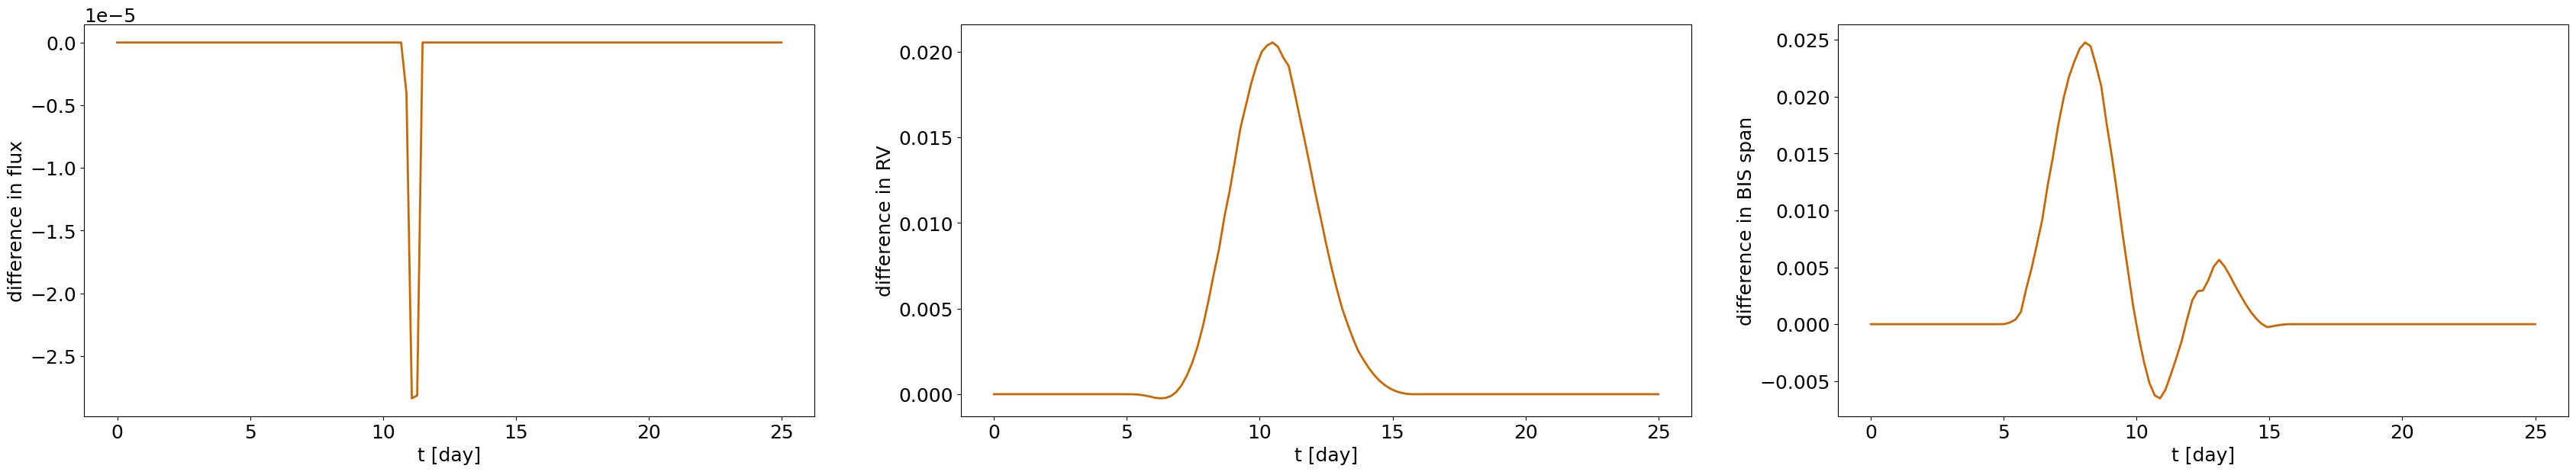

In [149]:
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2

sum_lc = np.sum(lc_list, axis=0) - (len(lc_list) - 1)
sum_rv = np.sum(rv_list, axis=0) 
sum_bis = np.sum(bis_list, axis=0) - (len(lc_list) - 1) * bis_list[0][0]

colors = ['#336b8b', '#f0b51f', '#83984d']

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(60 / 1.5 + 2, 10 / 1.5))

ax[0].plot(t, lc_tot, label='Total', color='#CA6702')

for i in range(len(lc_list)):
    ax[0].plot(t, lc_list[i], '--', label='Region {:.0f}'.format(i), color=colors[i])
    ax[1].plot(t, rv_list[i], '--', label='Region {:.0f}'.format(i), color=colors[i])
    ax[2].plot(t, bis_list[i], '--', label='Region {:.0f}'.format(i), color=colors[i])




# idxs = np.argwhere(np.abs(lc_tot - lc_list[0] - lc_list [1] - lc_list[2] + 2)>1e-6)

# for idx in idxs:
#     ax[0].axvline(t[idx], color='black', alpha=0.4)

ax[0].legend(fontsize=16)

ax[0].set_xlabel('t [day]')
ax[0].set_ylabel('relative flux intensity')

ax[1].plot(t, rv_tot, label='Total', color='#CA6702')

ax[1].legend(fontsize=16)

ax[1].set_xlabel('t [day]')
ax[1].set_ylabel('RV')

ax[2].plot(t, bis_tot, label='Total', color='#CA6702')

ax[2].legend(fontsize=16)

ax[2].set_xlabel('t [day]')
ax[2].set_ylabel('BIS span')

plt.savefig(pathdata+'test_distinct_q_dav/obs_Q_{}_r_{}_lat_{}_long_{}.pdf'.format(Q_list, spot_size_list, latitude_list, longitude_list), bbox_inches='tight')

plt.show()

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(60 / 1.5 + 2, 10 / 1.5))

ax[0].plot(t, lc_tot - sum_lc, color='#CA6702')
# for idx in idxs:
#     ax[0].axvline(t[idx])

ax[0].set_xlabel('t [day]')
ax[0].set_ylabel('difference in flux')

ax[1].plot(t, rv_tot - sum_rv, color='#CA6702')

ax[1].set_xlabel('t [day]')
ax[1].set_ylabel('difference in RV')

ax[2].plot(t, bis_tot - sum_bis, color='#CA6702')

ax[2].set_xlabel('t [day]')
ax[2].set_ylabel('difference in BIS span')

plt.savefig(pathdata+'test_distinct_q_dav/diff_Q_{}_r_{}_lat_{}_long_{}.pdf'.format(Q_list, spot_size_list, latitude_list, longitude_list), bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['font.size'] = 18

def update(frame, ax, fig, lags, t, lc, path_grid, vec_grids, types, color_dict):
    lag = lags[frame]

    # Plot flux intensity (only update the necessary parts)
    ax[1].clear()  # Clear previous plot to avoid overlapping
    ax[1].plot(t[:lag], lc[:lag], color='gray', alpha=0.2, linewidth=1)
    ax[1].plot(t, lc, color='#9B2226', marker='.', markersize=12, linewidth=0)


    ax[1].set_xlim(t.min(), t.max())
    ax[1].set_ylabel('relative flux intensity')
    ax[1].set_xlabel('t [day]')
    ax[1].ticklabel_format(axis='both', style='sci')

    # Scatter plot for the grid (precompute color and data)
    ax[0].clear()  # Clear previous scatter plot to avoid overlapping
    ax[0].scatter(vec_grids[lag][:, 1], vec_grids[lag][:, 2], 
                  color=[ color_dict[np.argmax(i)] for i in types[lag]], s=50, alpha=0.8)

    ax[0].locator_params(axis='y', nbins=5)
    ax[0].tick_params(grid_alpha=0.7)
    ax[1].tick_params(grid_alpha=0.7)

    fig.tight_layout()

def load_data(path_grid, t, lags):
    # Preload vec_grid and typ for each frame to avoid repeated loading
    vec_grids = []
    types = []
    for lag in lags:
        vec_grid = np.load(path_grid + 'vec_gridt{:.4f}.npy'.format(t[lag]))
        typ = np.load(path_grid + 'typt{:.4f}.npy'.format(t[lag]))
        vec_grids.append(vec_grid)
        types.append(typ)
    return vec_grids, types

# Initialize parameters
lc = ss.results['lc']
lags = np.arange(len(t))
color_dict = {0: '#CA6702', 1: '#9B2226', 2: '#EE9B00', 3: '#0A9396'}

# Preload data
vec_grids, types = load_data(path_grid, t, lags)

# Set up the figure and axis
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20 / 1.5 + 2, 10 / 1.5))

# Create the animation
ani = FuncAnimation(fig, partial(update, ax=ax, fig=fig, lags=lags, t=t, lc=lc, 
                                 path_grid=path_grid, vec_grids=vec_grids, types=types, 
                                 color_dict=color_dict), 
                    frames=len(lags), repeat=False)
output = '/home/sophie-stucki/Documents/starsim_simulations/test_multiple_q.gif'

# Save the animation
writer = FFMpegWriter(fps=3, metadata=dict(artist='Me'), bitrate=2400)
ani.save(output, writer=writer)

In [151]:
bis_list[0][0]

np.float64(-25.994028098771935)